In [3]:
#Install imbalanced-learn library (needed for SMOTE to handle class imbalance)
!pip install imbalanced-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Importing necessary libraries ##

In [4]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
warnings.filterwarnings('ignore')

## Data loading ##

In [7]:
# Define file path
file_path = r"C:\Users\user\Desktop\Future Interns\Sentiment analysis\sentimentdataset.csv"

# Load dataset without unnecessary unnamed columns
df = pd.read_csv(file_path)

# Remove unnamed columns explicitly if they exist
df = df.loc[:, ~df.columns.str.startswith('Unnamed')]

# Display first few rows
df.head()


,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,Sentiment_Categorized,Sentiment_Categorized_Num,processed_text,Word_Frequency
0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12,Positive,2,enjoying beautiful day park,4
1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8,Negative,0,traffic terrible morning,3
2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15,Positive,2,finished amazing workout,3
3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18,Positive,2,excited upcoming weekend getaway,4
4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19,Neutral,1,trying new recipe dinner tonight,5


In [8]:
column_names = df.columns.tolist()
print(column_names)


['Text', 'Sentiment', 'Timestamp', 'User', 'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month', 'Day', 'Hour', 'Sentiment_Categorized', 'Sentiment_Categorized_Num', 'processed_text', 'Word_Frequency']


In [9]:
df.shape

(712, 17)

## Data Cleaning ##

In [10]:
# Check for missing values in each column
df.isnull().sum()

Text                         0
Sentiment                    0
Timestamp                    0
User                         0
Platform                     0
Hashtags                     0
Retweets                     0
Likes                        0
Country                      0
Year                         0
Month                        0
Day                          0
Hour                         0
Sentiment_Categorized        0
Sentiment_Categorized_Num    0
processed_text               0
Word_Frequency               0
dtype: int64

In [11]:
# Drop duplicate rows
df = df.drop_duplicates()

## Sentiment Classification ##

In [12]:
df['Sentiment'].value_counts()

Sentiment
Positive           44
Joy                42
Excitement         32
Neutral            14
Happy              14
                   ..
Dazzle              1
Adrenaline          1
Harmony             1
ArtisticBurst       1
Elegance            1
Name: count, Length: 279, dtype: int64

In [13]:
unique_sentiments = df["Sentiment"].unique()
print(unique_sentiments)


[' Positive  ' ' Negative  ' ' Neutral   ' ' Anger        '
 ' Fear         ' ' Sadness      ' ' Disgust      ' ' Happiness    '
 ' Joy          ' ' Love         ' ' Amusement    ' ' Enjoyment    '
 ' Admiration   ' ' Affection    ' ' Awe          ' ' Disappointed '
 ' Surprise     ' ' Acceptance   ' ' Adoration    ' ' Anticipation '
 ' Bitter       ' ' Calmness     ' ' Confusion    ' ' Excitement   '
 ' Kind         ' ' Pride        ' ' Shame        ' ' Confusion '
 ' Excitement ' ' Shame ' ' Elation       ' ' Euphoria      '
 ' Contentment   ' ' Serenity      ' ' Gratitude     ' ' Hope          '
 ' Empowerment   ' ' Compassion    ' ' Tenderness    ' ' Arousal       '
 ' Enthusiasm    ' ' Fulfillment  ' ' Reverence     ' ' Compassion'
 ' Fulfillment   ' ' Reverence ' ' Elation   ' ' Despair         '
 ' Grief           ' ' Loneliness      ' ' Jealousy        '
 ' Resentment      ' ' Frustration     ' ' Boredom         '
 ' Anxiety         ' ' Intimidation    ' ' Helplessness    '
 ' 

In [14]:

# Define sentiment categories
positive_sentiments = {  
    "Positive", "Happy", "Happiness", "Joy", "Love", "Amusement", "Enjoyment", "Admiration", "Affection", "Awe", "Surprise", 
    "Acceptance", "Adoration", "Anticipation", "Calmness", "Excitement", "Kind", "Pride", "Elation", 
    "Euphoria", "Contentment", "Serenity", "Gratitude", "Hope", "Empowerment", "Compassion", "Tenderness", 
    "Arousal", "Enthusiasm", "Fulfillment", "Reverence", "Inspiration", "Motivation", "Playful", 
    "Free-spirited", "Inspired", "Confident", "Optimism", "Accomplishment", "Wonderment", "Creativity", 
    "Radiance", "Harmony", "Rejuvenation", "Coziness", "Adventure", "Festive Joy", "Freedom", "Dazzle", 
    "Artistic Burst", "Positivity", "Kindness", "Friendship", "Success", "Thrill", "Reflection", 
    "Exploration", "Romance", "Captivation", "Celebration", "Ecstasy", "Connection", "Journey", 
    "Engagement", "Touched", "Triumph", "Heartwarming", "Breakthrough", "Renewed Effort", "Solace", 
    "Joy in Baking", "Envisioning History", "Imagination", "Vibrancy", "Mesmerizing", "Culinary Adventure", 
    "Winter Magic", "Thrilling Journey", "Nature's Beauty", "Celestial Wonder", "Creative Inspiration", 
    "Runway Creativity", "Ocean's Freedom", "Whispers of the Past"
}  

negative_sentiments = {  
    "Negative", "Anger", "Fear", "Sadness", "Disappointed", "Bitter", "Shame", "Despair", "Grief", "Loneliness", 
    "Jealousy", "Resentment", "Frustration", "Boredom", "Anxiety", "Intimidation", "Helplessness", "Envy", 
    "Regret", "Disgust", "Confusion", "Melancholy", "Nostalgia", "Ambivalence", "Overwhelmed", "Devastated", 
    "Bitterness", "Yearning", "Fearful", "Apprehensive", "Dismissive", "Betrayal", "Suffering", "Emotional Storm", 
    "Isolation", "Lost Love", "Exhaustion", "Sorrow", "Darkness", "Desperation", "Ruins", "Desolation", 
    "Heartache", "Solitude", "Miscalculation", "Pressure", "Obstacle", "Hate", "Bad", "Sad"
}  

neutral_sentiments = {  
    "Neutral", "Indifference", "Curiosity", "Numbness", "Contemplation", "Reflection", "Satisfaction", 
    "Elegance", "Pensive", "Suspense", "Relief", "Embarrassed", "Mischievous", "Surprise"
}  

# Function to classify sentiments
def classify_sentiment(sentiment):
    sentiment = sentiment.strip()  # Remove spaces
    if sentiment in positive_sentiments:
        return "Positive"
    elif sentiment in negative_sentiments:
        return "Negative"
    else:
        return "Neutral"  # Default to neutral if not found

# Apply function to the Sentiment column
df['Sentiment_Categorized'] = df['Sentiment'].apply(classify_sentiment)


In [15]:
# Check unique values in the new column
df['Sentiment_Categorized'].unique()


array(['Positive', 'Negative', 'Neutral'], dtype=object)

In [16]:
print(df['Sentiment_Categorized'].value_counts())


Sentiment_Categorized
Positive    381
Negative    178
Neutral     153
Name: count, dtype: int64


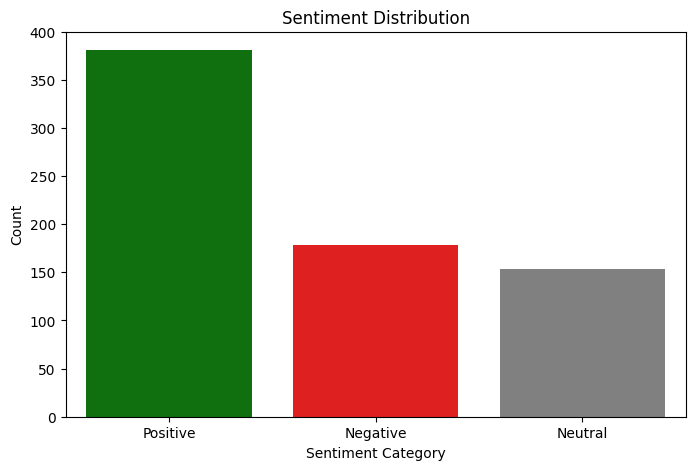

In [17]:
# Plot the sentiment distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=df['Sentiment_Categorized'].value_counts().index, 
            y=df['Sentiment_Categorized'].value_counts().values, 
            palette=['green', 'red', 'gray'])

# Add labels and title
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
plt.xticks(rotation=0)

# Show the plot
plt.show()


In [18]:
df.head()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,Sentiment_Categorized,Sentiment_Categorized_Num,processed_text,Word_Frequency
0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12,Positive,2,enjoying beautiful day park,4
1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8,Negative,0,traffic terrible morning,3
2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15,Positive,2,finished amazing workout,3
3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18,Positive,2,excited upcoming weekend getaway,4
4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19,Neutral,1,trying new recipe dinner tonight,5


In [19]:
# Map categorical sentiments to numerical values
sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
df['Sentiment_Categorized_Num'] = df['Sentiment_Categorized'].map(sentiment_mapping)

# Check if conversion is successful
print(df[['Sentiment_Categorized', 'Sentiment_Categorized_Num']].head())


  Sentiment_Categorized  Sentiment_Categorized_Num
0              Positive                          2
1              Negative                          0
2              Positive                          2
3              Positive                          2
4               Neutral                          1


In [20]:
df.head()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,Sentiment_Categorized,Sentiment_Categorized_Num,processed_text,Word_Frequency
0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12,Positive,2,enjoying beautiful day park,4
1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8,Negative,0,traffic terrible morning,3
2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15,Positive,2,finished amazing workout,3
3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18,Positive,2,excited upcoming weekend getaway,4
4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19,Neutral,1,trying new recipe dinner tonight,5


## Text Preprocessing ##

In [21]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

# Custom stopwords (keeping negations like "not", "never")
custom_stopwords = {'don', 'ain', 'aren', "aren't", 'couldn', "couldn't",
                    'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't",
                    'haven', "haven't", 'isn', "isn't", 'ma', 'might', "mightn't", 'mustn', "mustn't",
                    'needn', "needn't", 'shan', "shan't", 'no', 'nor', 'shouldn', "shouldn't",
                    'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"}

stop_words = set(stopwords.words("english")) - custom_stopwords  # Retain negation words
corpus = []

for i in range(len(df)):
    text = re.sub('[^a-zA-Z]', ' ', df.iloc[i]['Text'])  # Keep only letters
    text = text.lower().split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]  # Lemmatization & stopwords
    corpus.append(" ".join(text))

df['processed_text'] = corpus  # Add cleaned text column

# Check output
df[['Text', 'processed_text']].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Text,processed_text
0,Enjoying a beautiful day at the park! ...,enjoying beautiful day park
1,Traffic was terrible this morning. ...,traffic terrible morning
2,Just finished an amazing workout! 💪 ...,finished amazing workout
3,Excited about the upcoming weekend getaway! ...,excited upcoming weekend getaway
4,Trying out a new recipe for dinner tonight. ...,trying new recipe dinner tonight


In [24]:
# Save cleaned DataFrame to CSV
df.to_csv("cleaned_trending_topics.csv", index=False, encoding="utf-8")


In [25]:
print(df.columns)  # Displays all column names


Index(['Text', 'Sentiment', 'Timestamp', 'User', 'Platform', 'Hashtags',
       'Retweets', 'Likes', 'Country', 'Year', 'Month', 'Day', 'Hour',
       'Sentiment_Categorized', 'Sentiment_Categorized_Num', 'processed_text',
       'Word_Frequency'],
      dtype='object')


## Word Frequency Analysis ##

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Convert processed text into a list
text_data = df['processed_text'].dropna().tolist()

# Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=20)  # Top 20 words
X = vectorizer.fit_transform(text_data)

# Get word frequency
word_freq = pd.DataFrame({'Word': vectorizer.get_feature_names_out(), 'Frequency': X.toarray().sum(axis=0)})
word_freq = word_freq.sort_values(by='Frequency', ascending=False)

# Display top words
print(word_freq)


        Word  Frequency
16       new         43
12      life         35
2        day         29
10       joy         28
6    feeling         27
14    moment         27
13      like         27
7     friend         26
8      heart         24
3      dream         23
17     night         23
18      time         22
19     world         22
0        art         21
11  laughter         20
1     beauty         20
9    journey         20
5    emotion         20
4       echo         20
15    nature         19


In [27]:
from collections import Counter
import pandas as pd

# Load existing cleaned data
df = pd.read_csv("cleaned_trending_topics.csv")

# Function to count words in each row
def count_words(text):
    words = text.split()
    return len(words)

# Apply word count function to 'processed_text' column
df["Word_Frequency"] = df["processed_text"].apply(count_words)

# Save updated dataset (overwrite existing file)
df.to_csv("cleaned_trending_topics.csv", index=False, encoding="utf-8")

print("Updated dataset saved with Word_Frequency column!")


Updated dataset saved with Word_Frequency column!


## Topic Modeling using LatentDirichletAllocation ##

In [28]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# Convert text data into a document-term matrix
X = vectorizer.fit_transform(text_data)

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5 topics
lda.fit(X)

# Display top words per topic
def display_topics(model, feature_names, n_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}: ", [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]])

display_topics(lda, vectorizer.get_feature_names_out(), 10)


Topic 1:  ['life', 'friend', 'echo', 'heart', 'laughter', 'joy', 'night', 'dream', 'moment', 'emotion']
Topic 2:  ['joy', 'feeling', 'moment', 'art', 'laughter', 'time', 'friend', 'beauty', 'day', 'life']
Topic 3:  ['day', 'time', 'emotion', 'beauty', 'nature', 'moment', 'feeling', 'new', 'like', 'joy']
Topic 4:  ['like', 'dream', 'journey', 'laughter', 'heart', 'echo', 'joy', 'life', 'time', 'night']
Topic 5:  ['new', 'night', 'world', 'nature', 'beauty', 'art', 'time', 'journey', 'laughter', 'life']


## Sentiment Trend Analysis ##

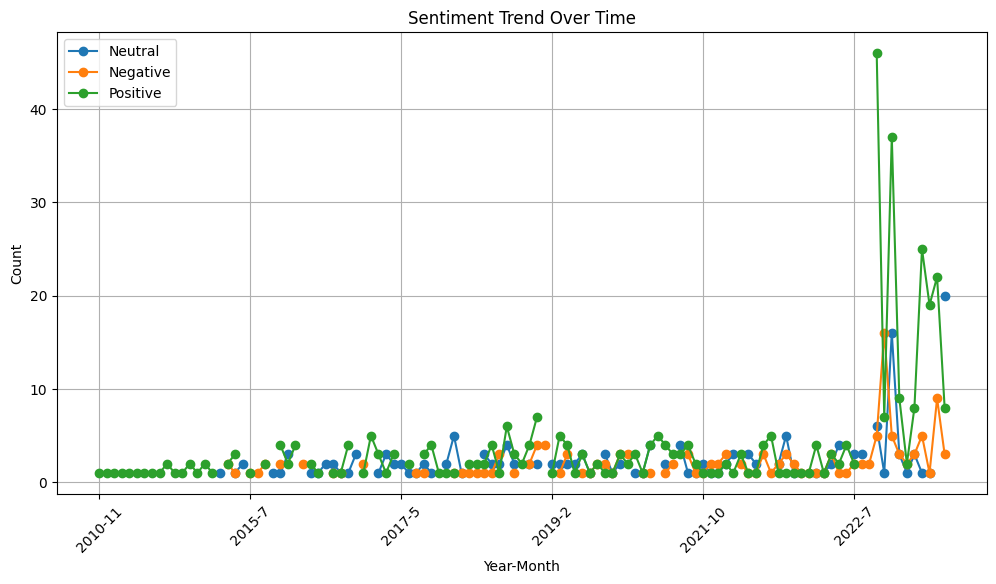

In [29]:
import matplotlib.pyplot as plt

# Group by Year-Month and count sentiments
df['Year-Month'] = df['Year'].astype(str) + '-' + df['Month'].astype(str)
trend_data = df.groupby(['Year-Month', 'Sentiment_Categorized_Num'])['Sentiment'].count().unstack()

# Plot trend
trend_data.plot(kind='line', marker='o', figsize=(12,6))
plt.title('Sentiment Trend Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.legend(['Neutral', 'Negative', 'Positive'])
plt.xticks(rotation=45)
plt.grid()
plt.show()


## Dimensionality Reduction with SVD ##

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

tfidf = TfidfVectorizer(
    max_features=1000,    # Increase word coverage
    stop_words='english',
    min_df=10,            # Lower min_df to capture more words
    max_df=0.8,           # Avoid very frequent words
    ngram_range=(1,2),    # Include bigrams
    sublinear_tf=True     # Scale frequent words
)

X_tfidf = tfidf.fit_transform(df['processed_text'])
# Step 2: Apply Truncated SVD for Dimensionality Reduction
svd = TruncatedSVD(n_components=min(50, X_tfidf.shape[1]), random_state=42)  # Reduce dimensions
X_reduced = svd.fit_transform(X_tfidf)

# Step 3: Check Explained Variance (should be high, like ~90%)
explained_variance = svd.explained_variance_ratio_.sum()
print(f"Explained Variance: {explained_variance:.2f}")

Explained Variance: 0.82


## Model Building,Model training and Model Evaluation ##

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [35]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (914, 50)
y_train shape: (914,)


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Step 1: Define X (features) and y (target)
X = X_reduced
y = df['Sentiment_Categorized_Num']  # Assuming 0=Neutral, 1=Negative, 2=Positive

# Step 2: Apply SMOTE for balancing classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 4: Train RandomForest Model
model = RandomForestClassifier(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

# Step 5: Evaluate Model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Model Accuracy: 0.7293
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.89      0.74        71
           1       0.83      0.66      0.74        76
           2       0.78      0.66      0.72        82

    accuracy                           0.73       229
   macro avg       0.75      0.73      0.73       229
weighted avg       0.75      0.73      0.73       229



In [44]:
import pickle

# Save the trained TF-IDF Vectorizer
with open("tfidf_vectorizer.pkl", "wb") as file:
    pickle.dump(tfidf, file)

print("✅ TF-IDF Vectorizer saved successfully!")


✅ TF-IDF Vectorizer saved successfully!


## Hyperparameter tuning using randomized search ##

In [45]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define hyperparameter grid
param_dist = {
    'n_estimators': [300, 400, 500, 600],
    'max_depth': [18, 20, 24, 28],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': [{0: 1.2, 1: 1.0, 2: 2.0}, {0: 1.5, 1: 1.2, 2: 2.5}]
}

# Create model
rf = RandomForestClassifier(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # Try 20 different combinations
    cv=5,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit search
random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", random_search.best_params_)

# Best model
best_rf = random_search.best_estimator_

# Evaluate
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized Model Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 18, 'class_weight': {0: 1.5, 1: 1.2, 2: 2.5}}
Optimized Model Accuracy: 0.7293
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.89      0.74        71
           1       0.85      0.67      0.75        76
           2       0.77      0.65      0.70        82

    accuracy                           0.73       229
   macro avg       0.75      0.73      0.73       229
weighted avg       0.75      0.73      0.73       229



## Saving the model ##

In [46]:
import pickle

# Define the model save path
model_path = "random_forest_model.pkl"

# Save the model
with open(model_path, "wb") as file:
    pickle.dump(best_rf, file)

print("✅ Model saved successfully!")


✅ Model saved successfully!


In [47]:
import pickle

# Load the model
model_path = "random_forest_model.pkl"

try:
    with open(model_path, "rb") as file:
        model = pickle.load(file)
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model: {e}")


✅ Model loaded successfully!
